# DMQC Report: WMO 4900874

## Current status and metadata: 

- APEX float that completed 168 cycles over 4.6 years (2006-2011) in the North Pacific
- Previously adjusted by Henry Bittig using in-air data to calculate T-dependent gain with slope over time
- Mean gain is 1.0581
- Mean WOA gain is 1.0669
- Will just visually inspect, remove bad data, keep existing gain

In [1]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.dates import datestr2num
import matplotlib.pyplot as plt

from netCDF4 import Dataset

from pathlib import Path
import numpy as np
import pandas as pd
import bgcArgoDMQC as bgc

wmo = 4900874 # insert WMO number here
fig_path = Path('../../../figures/') / f'{wmo}' # where to save figures
fig_path.mkdir(exist_ok=True)
bgc.io.get_argo(wmo, local_path=bgc.io.Path.ARGO_PATH) # download the data to ensure you have up to date files
flt = bgc.sprof(wmo)
flt.clean()
gains = flt.calc_gains(ref='WOA') # calculate gain, can change to ref='NCEP' if in-air data is available
print(np.nanmean(gains))

nc = Dataset(flt.__Sprof__)
print(bgc.io.read_ncstr(nc['SCIENTIFIC_CALIB_COMMENT'][:][50,-1,3,:]))
print(nc['DOXY_ADJUSTED'][:][-1,:]/nc['DOXY'][:][-1,:])
print(np.nanmean(nc['DOXY_ADJUSTED'][:]/nc['DOXY'][:]))
nc.close()

\Users\GordonC\Documents\data\Argo\dac\meds\4900874\4900874_Rtraj.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900874\4900874_Sprof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900874\4900874_meta.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900874\4900874_prof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900874\4900874_tech.nc
Extracting WOA data for Jan
Extracting WOA data for Feb
Extracting WOA data for Mar
Extracting WOA data for Apr
Extracting WOA data for May
Extracting WOA data for Jun
Extracting WOA data for Jul
Extracting WOA data for Aug
Extracting WOA data for Sep
Extracting WOA data for Oct
Extracting WOA data for Nov
Extracting WOA data for Dec

Calculating gains using WOA surface data and float O2 percent saturation...
1.0669216501351784
by Henry Bittig; ORCID 0000-0002-8621-3095; after Bittig et al. (2018) eq. 23 T-dependent slope on PPOX_DOXY with linear time trend in slope; Using in-air obs; No time response correction done; error gives 1 sigma
[1.050459027

## Visual QC

- Visualize the float and reference surface saturations, as well as the profiles. 
- Observe if DOXY data is set to '3' as it should be or if it is '1' or '2'. 
- Try to note cycles or other identifying features of potentially problematic profiles.

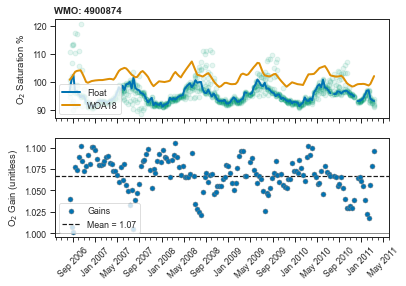

In [2]:
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_initial.png', bbox_inches='tight', dpi=250)

Figure 1: Top panel: Float oxygen percent saturation (blue line) compared to WOA percent saturation (orange line), with DOXY audit flagged cycle percent saturation (green stars, if applicable) and raw float percent saturation (orange circles). Bottom panel: calculated gains (blue dots) and flagged gains from DOXY audit (orange stars).

Notes: [notes on what this figure tells you here] 

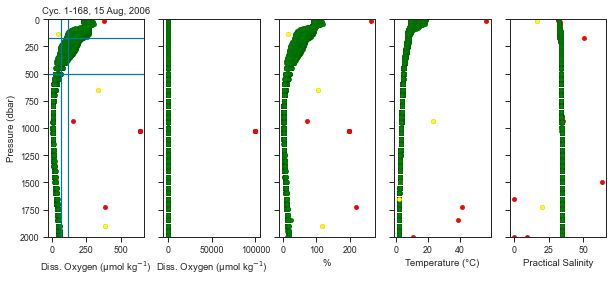

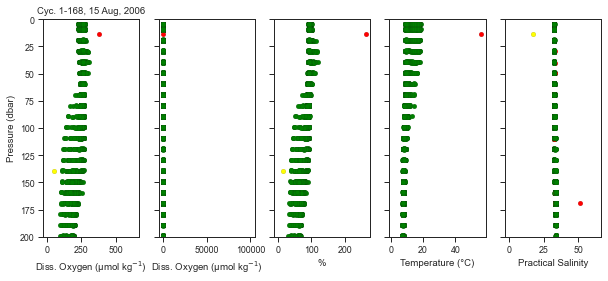

In [3]:
flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[0].axhline(500)
g.axes[0].axvline(120)
g.axes[0].axhline(175)
g.axes[0].axvline(70)
g.fig.savefig(fig_path / 'qcprofiles.png', bbox_inches='tight', dpi=250)
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((200,0))
g.fig.savefig(fig_path / 'qcprofiles_shallow.png', bbox_inches='tight', dpi=250)

Figures 2,3: Profiles coloured by QC flag (1-2, green, 3, yellow, 4, red) on difference depth scales.

Notes: [notes on what this figure tells you here] 

## Flag bad data, recalculate gain

- Using the plots above (and likely some more specific plots, made on a case-by-case basis), flag bad DOXY data as 4. 
- After flagging bad data, re-clean the data and re-calculate the gains.


Calculating gains using WOA surface data and float O2 percent saturation...
1.0669216501351784


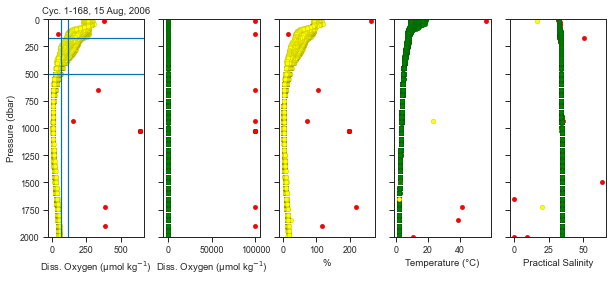

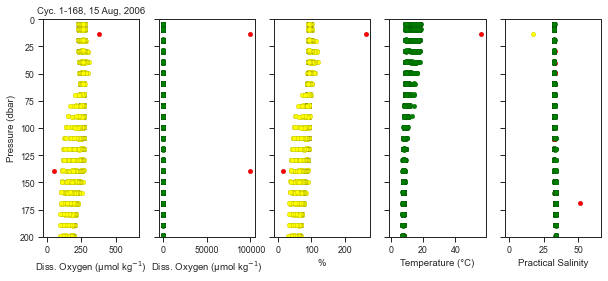

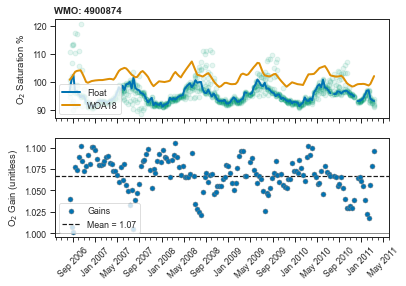

In [7]:
bad_oxygen = ((flt.PRES > 500) & (flt.DOXY > 120)) | ((flt.PRES < 175) & (flt.DOXY < 70)) # index defining where the oxygen should be flagged as bad
flt.update_field('DOXY_QC', 4, where=bad_oxygen)
flt.update_field('DOXY_ADJUSTED_QC', 4, where=bad_oxygen)
flt.clean()
new_gains = flt.calc_gains(ref='WOA')
print(np.nanmean(new_gains))

flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[0].axhline(500)
g.axes[0].axvline(120)
g.axes[0].axhline(175)
g.axes[0].axvline(70)
g.fig.savefig(fig_path / 'qcprofiles_postqc.png', bbox_inches='tight', dpi=250)
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((200,0))
g.fig.savefig(fig_path / 'qcprofiles_shallow_postqc.png', bbox_inches='tight', dpi=250)

flt.clean()
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_final.png', bbox_inches='tight', dpi=250)

Figure x: Repeated gain plot with bad data removed.

## Update Fields and Export

- DOXY should be 3 by default, but many old floats have 1 or 0. Though it will be redundant in some cases, make sure DOXY_QC is not good.
- Apply the gain to calculate DOXY_ADJUSTED. 
- Fill in DOXY_ADJUSTED_ERROR with an appropriate fixed value.
- Fill in DOXY_ADJUSTED_QC. 
- Make sure DOXY_ADJUSTED and DOXY_ADJUSTED_ERROR are `FillValue` wherever DOXY_ADJUSTED_QC is bad.
- Export the D-mode files. During export, HISTORY parameters will be filled as well as SCIENTIFIC_CALIB parameters using some default structures and user info set by calling `bgc.configure.configure()`.

In [5]:
# make sure DOXY_QC is 3 instead of 0,1,2
flt.update_field('DOXY_QC', 3, where=flt.DOXY_QC.isin([0, 1, 2]))
# fill in DOXY_ADJUSTED_QC appropriately
# flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.TEMP_ADJUSTED_QC == 4)
# flt.update_field('DOXY_ADJUSTED_QC', 3, where=flt.PSAL_ADJUSTED_QC == 4)
# make sure the data is FillValues where adjusted values are still bad
flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.DOXY_ADJUSTED.isna())
flt.set_fillvalue('DOXY_ADJUSTED', where=flt.DOXY_ADJUSTED_QC == 4)
flt.set_fillvalue('DOXY_ADJUSTED_ERROR', where=flt.DOXY_ADJUSTED_QC == 4)

In [8]:
# export the files
comment = 'by Henry Bittig; ORCID 0000-0002-8621-3095; after Bittig et al. (2018) eq. 23 T-dependent slope on PPOX_DOXY with linear time trend in slope; Using in-air obs; No time response correction done; error gives 1 sigma'
comment += f"; Visual QC by Christopher Gordon (DFO, ORCID {bgc.config['orcid']})"
comment = comment.replace('No time response correction done;', '')
flt.export_files(data_mode='D', comment=comment, coeff='previous', equation='previous')

Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900874/profiles/BD4900874_001.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900874/profiles/BD4900874_002.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900874/profiles/BD4900874_003.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900874/profiles/BD4900874_004.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900874/profiles/BD4900874_005.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900874/profiles/BD4900874_006.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900874/profiles/BD4900874_007.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900874/profiles/BD4900874_008.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900874/profiles/BD4900874_009.nc...done
Working on

In [2]:
from pathlib import Path
import pandas as pd
from netCDF4 import Dataset
import copy

wmo = 4900874
loc = Path(f'/Users/GordonC/Documents/data/Argo/dac/meds/D/{wmo}/profiles/')
files = pd.read_csv(Path(f'../../../checker/summary/{wmo}/files.txt'))
varname = 'DOXY'
for fn in files.files:
    print(fn)
    nc = Dataset(loc / fn, 'r+')
    print(nc['DOXY'][:])
    flags = copy.deepcopy(nc[varname+'_QC'][:])
    flags[nc[varname][:].mask] = b'9'
    nc[varname+'_QC'][:] = flags
    if varname == 'DOXY':
        flags = copy.deepcopy(nc[varname+'_ADJUSTED_QC'][:])
        flags[nc[varname][:].mask] = b'9'
        nc[varname+'_ADJUSTED_QC'][:] = flags
    profile = copy.deepcopy(nc['PROFILE_DOXY_QC'][:])
    profile[0] = b'A'
    nc['PROFILE_DOXY_QC'][:] = profile
    nc.close()

BD4900874_040.nc
[[234.95370483398438 234.89471435546875 235.8899383544922
  255.85118103027344 252.00096130371094 249.34075927734375
  248.49305725097656 249.143310546875 248.16546630859375
  244.9346160888672 241.58815002441406 233.7252655029297
  225.24620056152344 216.87857055664062 199.993896484375
  186.49713134765625 183.90478515625 182.0689239501953 178.75880432128906
  175.5181121826172 171.29544067382812 163.89549255371094
  158.0661163330078 154.4783935546875 149.8095245361328 145.9693145751953
  140.3175048828125 135.81536865234375 129.45181274414062
  124.37533569335938 120.44853210449219 115.7520523071289
  112.41004943847656 107.2948226928711 100.48503875732422
  97.1621322631836 91.37537384033203 80.6892318725586 75.0481185913086
  65.40330505371094 53.68430709838867 41.178714752197266
  31.449861526489258 22.987445831298828 14.944504737854004
  11.059407234191895 9.686380386352539 7.826724052429199 6.63888692855835
  --]]
BD4900874_106.nc
[[249.43447875976562 249.95892